# 1. Vehicle Routing Problem (VRP) demo with OSMnx and OR-Tools

This repository demonstrates the usage of [OR-Tools](https://developers.google.com/optimization) and [OSMnx](https://github.com/gboeing/osmnx).

## What is VRP?
Vehicle Routing Problem (VRP) is a combinatorial optimization problem that involves finding the optimal set of routes for a fleet of vehicles to visit a set of locations, subject to various constraints. It is a well-known problem in the field of operations research and has many practical applications such as logistics, transportation, and supply chain management.

## What is OR-Tools?
OR-Tools is an open-source software suite for optimization developed by Google. It includes a wide range of solvers and tools for solving various types of optimization problems, including VRP.

## What is OSMnx?
OSMnx is a Python library for working with [OpenStreetMap](https://www.openstreetmap.org/) (OSM) data. It allows you to download OSM data, visualize it, and perform various spatial analyses on it. In this notebook, we will use OSMnx to download street network data for a specific location.

## What is the goal of this notebook?
The goal of this notebook is to demonstrate how to solve a VRP using OR-Tools and OSMnx. Specifically, we will use OSMnx to download street network data for a specific location, and then use OR-Tools to find the optimal set of routes for a fleet of vehicles to visit a set of bus stops in that location, subject to various constraints such as vehicle capacity and maximum distance traveled. Finally, we will visualize the results on a map using folium. This notebook is intended for anyone who is interested in learning about VRP, OR-Tools, and OSMnx, regardless of their level of expertise in these areas.

In [66]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [69]:
import pandas as pd

# Read the CSV file
data = pd.read_csv('Data_Alfamart Indomaret_South Jakarta_Filtered.csv')

# Specify the list of kelurahan names
kelurahan_list = ['Tebet', 'Pancoran', 'Pasar Minggu', 'Jagakarsa', 'Cilandak', 
                  'Kebayoran Lama', 'Pesanggrahan', 'Kebayoran Baru', 
                  'Mampang Prapatan', 'Setiabudi']

# Initialize a dictionary to store center locations
CENTER_LOCATIONS = {}

# Loop through each kelurahan name
for kelurahan in kelurahan_list:
    # Filter the data for the current kelurahan
    kelurahan_data = data[data['nama_kelurahan'] == kelurahan]
    
    # Calculate the center location (mean latitude and longitude)
    center_location = (kelurahan_data['lat'].mean(), kelurahan_data['lng'].mean())
    
    # Store the center location in the dictionary
    CENTER_LOCATIONS[kelurahan] = center_location

# Display the computed center locations
for kelurahan, location in CENTER_LOCATIONS.items():
    print(f"{kelurahan}: {location}")


Tebet: (nan, nan)
Pancoran: (-6.251629149999999, 106.83849725)
Pasar Minggu: (-6.29361675, 106.83926515)
Jagakarsa: (-6.323801657142857, 106.81510819999998)
Cilandak: (nan, nan)
Kebayoran Lama: (nan, nan)
Pesanggrahan: (-6.2500459, 106.7566562)
Kebayoran Baru: (nan, nan)
Mampang Prapatan: (nan, nan)
Setiabudi: (nan, nan)


In [65]:
data

,nama_tempat,rating_tempat,user_ratings_total,lat,lng,alamat_tempat,place_id,store,place_id.1,nama_kelurahan,nama_kecamatan,nama_kota
0,indomaret,4.3,104,-6.302203,106.791936,"jl. lb. bulus iii no.40, rt.9/rw.7, cilandak b...",ChIJaxj8TyDuaS4RmJ8rDkpB2GA,Indomaret,ChIJaxj8TyDuaS4RmJ8rDkpB2GA,Cilandak Barat,Cilandak,Kota Jakarta Selatan
1,indomaret,0.0,0,-6.307003,106.793690,"10, rt.4/rw.10, pondok labu, south jakarta city",ChIJPz4W5BPvaS4RoUnKBAiaL3o,Indomaret,ChIJPz4W5BPvaS4RoUnKBAiaL3o,Pondok Labu,Cilandak,Kota Jakarta Selatan
2,indomaret bdn raya,4.2,66,-6.279392,106.798442,"jl. bdn raya no.10, rt.10/rw.11, cilandak bar....",ChIJKZqyypTxaS4RkjwUtyXrkBY,Indomaret,ChIJKZqyypTxaS4RkjwUtyXrkBY,Cilandak Barat,Cilandak,Kota Jakarta Selatan
3,indomaret,4.7,3,-6.278223,106.797096,"jl. rs. fatmawati raya no.7, rt.8/rw.6, gandar...",ChIJzVqDlcTxaS4Rwlnqrz5hXbo,Indomaret,ChIJzVqDlcTxaS4Rwlnqrz5hXbo,Gandaria Selatan,Cilandak,Kota Jakarta Selatan
4,indomaret karang tengah raya,4.3,108,-6.301344,106.780550,"bona indah plaza, jl. karang tengah raya no.1,...",ChIJ7aqqqinuaS4RKy68g0RuyMk,Indomaret,ChIJ7aqqqinuaS4RKy68g0RuyMk,Lebak Bulus,Cilandak,Kota Jakarta Selatan
...,...,...,...,...,...,...,...,...,...,...,...,...
95,indomaret tebet barat in tk29,4.2,149,-6.238346,106.847226,"jl. tebet barat dalam ivd no.88, rw.6, tebet b...",ChIJ7ahV373zaS4Rm9rs7VrGTVg,Indomaret,ChIJ7ahV373zaS4Rm9rs7VrGTVg,Tebet Barat,Tebet,Kota Jakarta Selatan
96,indomaret pal batu 36,4.3,70,-6.224740,106.844751,"jl. pal batu raya no.36, rt.13/rw.4, menteng d...",ChIJtX8wqY3zaS4RTpmMPQzAFbg,Indomaret,ChIJtX8wqY3zaS4RTpmMPQzAFbg,Menteng Dalam,Tebet,Kota Jakarta Selatan
97,indomaret,4.2,421,-6.229205,106.847449,"jl. prof supomo no 321 blok bz persil no 19, r...",ChIJxf__P5bzaS4RZ7KfkYohoDc,Indomaret,ChIJxf__P5bzaS4RZ7KfkYohoDc,Tebet Barat,Tebet,Kota Jakarta Selatan
98,indomaret al barkah,4.6,18,-6.220490,106.847233,"jl. albarkah no.20, rt.7/rw.3, manggarai sel.,...",ChIJk___P4nzaS4RKHnkXKOuy64,Indomaret,ChIJk___P4nzaS4RKHnkXKOuy64,Manggarai Selatan,Tebet,Kota Jakarta Selatan


-----

In [86]:
# Specify the center location (latitude, longtitude)
CENTER_LOCATION = (-6.302203,106.7919364)

# Specify distance in meters
DIST = 500

# Specify the number of vehicles
NUM_VEHICLES = 4

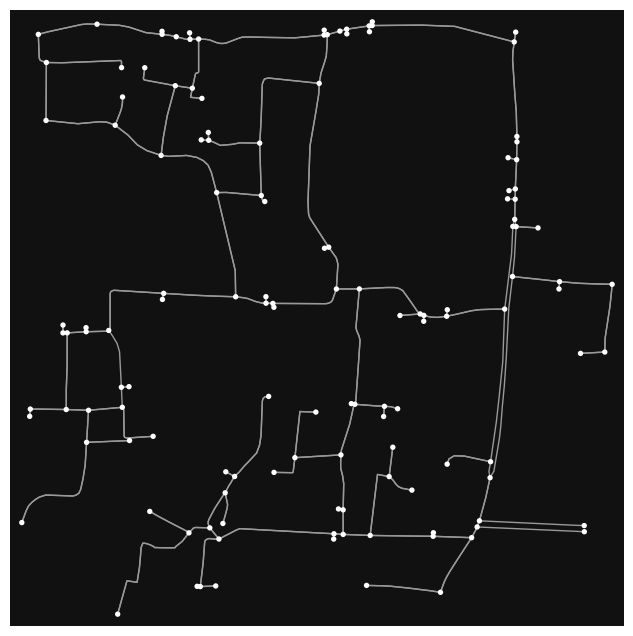

In [87]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
*_, = ox.plot_graph(G)

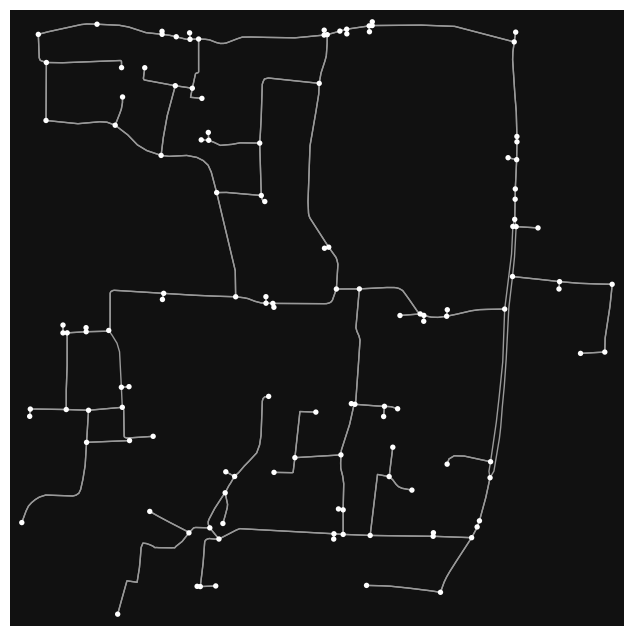

In [88]:
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
*_, = ox.plot_graph(G)

In [89]:
# Use the nearest node to the center location as the depot
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])
depot

3639024731

In [90]:
# Find bus stops
bus_stops = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)

# Get the nearest nodes to bus stops
bus_stop_nodes = list(map(itemgetter(1), bus_stops.index.values))
bus_stop_nodes[:5]

C:\Users\muham\AppData\Local\Temp\ipykernel_3864\57253982.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.
  bus_stops = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)


[9598703117, 9742626417, 9742626418, 9742626517, 9742626518]

In [91]:
# Combine depot and bus_stops
nodes = [depot] + bus_stop_nodes
nodes[:7]

[3639024731,
 9598703117,
 9742626417,
 9742626418,
 9742626517,
 9742626518,
 9742626617]

In [92]:
# Add bus stops to the highway graph
for index, bus_stop in bus_stops.iterrows():
    nearest_node = ox.distance.nearest_nodes(G, bus_stop.geometry.x, bus_stop.geometry.y)
    distance = geopy.distance.distance((G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x']), (bus_stop.geometry.y, bus_stop.geometry.x))

    # Add bus stop node
    G.add_node(index[1], x=bus_stop.geometry.x, y=bus_stop.geometry.y)
    
    # Add bidirectional edge
    G.add_edge(index[1], nearest_node, weight=distance.m)
    G.add_edge(nearest_node, index[1], weight=distance.m)

# Get edges as GeoDataFrames
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.head()

osmid oneway lanes   
u         v          key                                         
356233263 8520008311 0                  157366295  False     1  \
          1695849734 0                   31814826  False     2   
          4984362019 0                  509162232  False     2   
356233575 9782309644 0                  311483658  False     1   
          7675707342 0    [1038131192, 311483658]  False     1   

                                            name      highway width   
u         v          key                                              
356233263 8520008311 0       Jalan Pondok Labu I  residential     3  \
          1695849734 0    Jalan Pondok Labu Raya    secondary     8   
          4984362019 0        Jalan RS Fatmawati    secondary   NaN   
356233575 9782309644 0        Jalan RS Fatmawati    secondary     4   
          7675707342 0        Jalan RS Fatmawati    secondary     4   

                               reversed   length   
u         v          key                           
356233263 8520008311 0            False   62.806  \
          1695849734 0             True  102.945   
          4984362019 0            False   19.681   
356233575 9782309644 0             True    8.740   
          7675707342 0    [False, True]  154.627   

                                                                   geometry   
u         v          key                                                      
356233263 8520008311 0    LINESTRING (106.79412 -6.30553, 106.79355 -6.3...  \
          1695849734 0    LINESTRING (106.79412 -6.30553, 106.79389 -6.3...   
          4984362019 0    LINESTRING (106.79412 -6.30553, 106.79419 -6.3...   
356233575 9782309644 0    LINESTRING (106.79479 -6.29965, 106.79479 -6.2...   
          7675707342 0    LINESTRING (106.79479 -6.29965, 106.79478 -6.2...   

                          weight est_width bridge  
u         v          key                           
356233263 8520008311 0       NaN       NaN    NaN  
          1695849734 0       NaN       NaN    NaN  
          4984362019 0       NaN       NaN    NaN  
356233575 9782309644 0       NaN       NaN    NaN  
          7675707342 0       NaN       NaN    NaN

<Figure size 640x480 with 0 Axes>

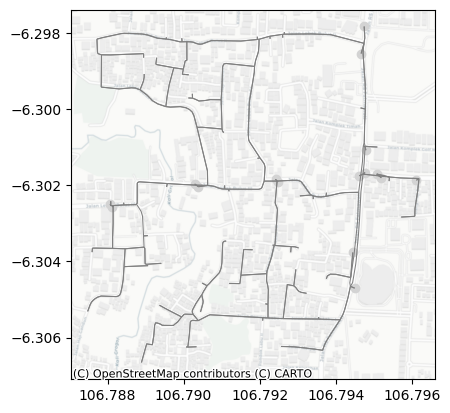

In [93]:
# Create a new figure object
ax = plt.figure()

# Plot the highway graph
ax = edges.plot(linewidth=0.75, color='gray')

# Plot the bus stops
ax = bus_stops.plot(ax=ax, facecolor='lightgray')

# Turn off offsetting of tick labels
ax.ticklabel_format(useOffset=False)

# Add a basemap to the figure object
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.CartoDB.Positron)

In [94]:
# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(nodes), NUM_VEHICLES, nodes.index(depot))

# Create routing model
routing = pywrapcp.RoutingModel(manager)

In [95]:
# Define distance callback
def distance_callback(from_node_index, to_node_index):
    from_node = nodes[manager.IndexToNode(from_node_index)]
    to_node = nodes[manager.IndexToNode(to_node_index)]
    return nx.shortest_path_length(G, from_node, to_node)

# Register distance callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [96]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [97]:
# Set path-cheapest-arc search strategy
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [98]:
# Print the solution
total_distance = 0
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route_distance = 0
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
    route.append(manager.IndexToNode(index))
    print(f"Route for vehicle {vehicle_id}:\n{' -> '.join(str(node) for node in route)}")
    print(f"Distance of route: {route_distance}m\n")
    total_distance += route_distance
print(f"Total distance of all routes: {total_distance}m")

Route for vehicle 0:
0 -> 4 -> 2 -> 6 -> 1 -> 12 -> 15 -> 0
Distance of route: 28m

Route for vehicle 1:
0 -> 8 -> 9 -> 0
Distance of route: 22m

Route for vehicle 2:
0 -> 14 -> 13 -> 10 -> 11 -> 0
Distance of route: 24m

Route for vehicle 3:
0 -> 5 -> 7 -> 16 -> 3 -> 0
Distance of route: 28m

Total distance of all routes: 102m


In [99]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for index, bus_stop in bus_stops.iterrows():
    stop_coords = (bus_stop.geometry.y, bus_stop.geometry.x)
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='bus', prefix='fa'), tooltip=f"Bus Stop {stop_coords}").add_to(m)

# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']

# Plot routes
for vehicle_id in range(NUM_VEHICLES):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % NUM_VEHICLES]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m